In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from matplotlib import rcParams
rcParams['font.family'] = 'Angsana New'
rcParams.update({'font.size': 22})
rcParams['axes.unicode_minus'] = False

In [3]:
# df_read = pd.read_csv('data/corrected_data.csv')
# df_read = pd.read_csv('data/meter_corrected.csv')
# df_read = pd.read_csv('data/chol-bangkla-corrected-2017-2022-hourly-corrected.csv', parse_dates=["datetime"])
df_read = pd.read_csv('data/chol-bangkla-corrected-2017-2022-hourly.csv', parse_dates=["datetime"])

In [4]:
df = df_read.copy()
print(df.dtypes)

datetime    datetime64[ns]
ec                 float64
dtype: object


In [5]:
df = df.loc[df["datetime"].dt.year==2022]
df.sort_values(by=['datetime'],inplace=True)
df.reset_index(drop=True,inplace=True)

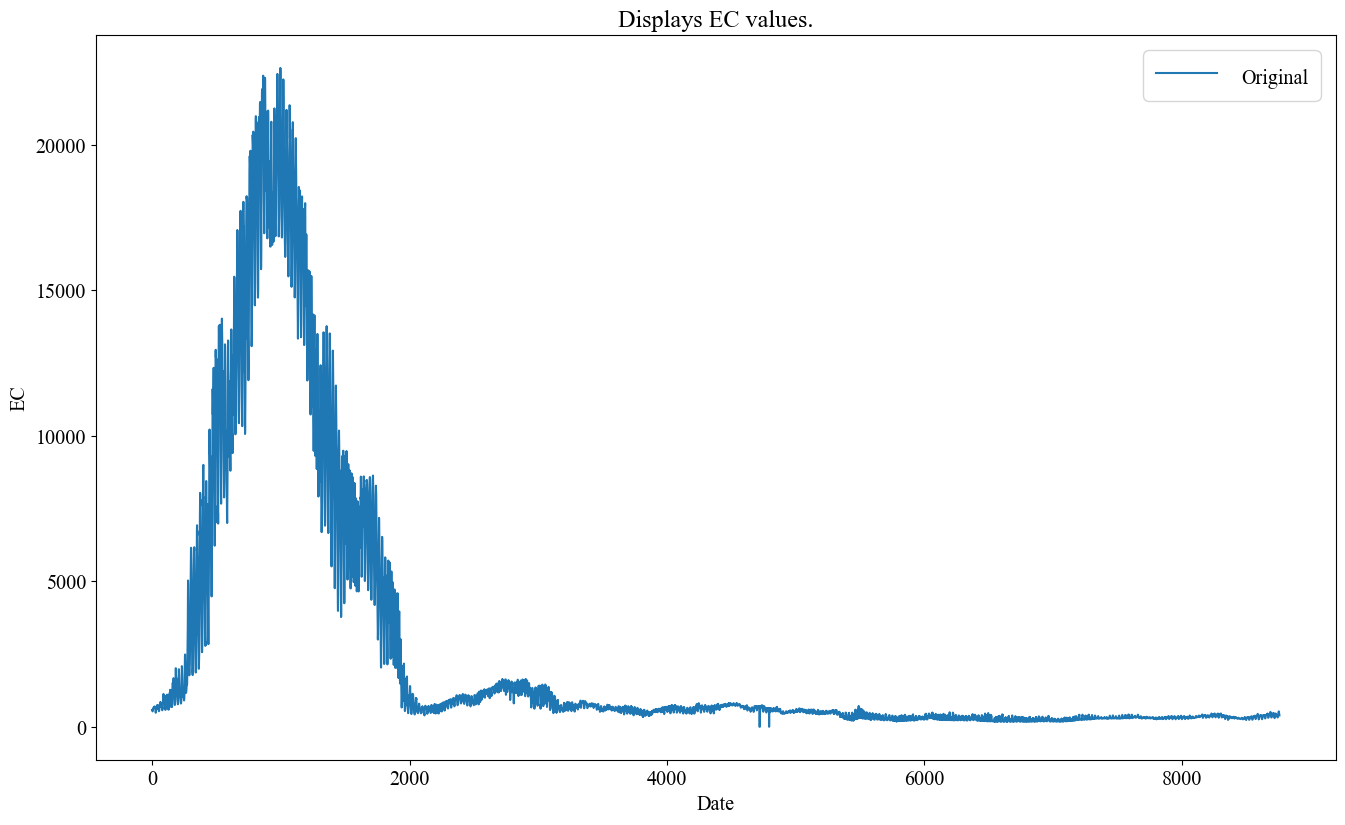

In [6]:
plt.figure(figsize=(16,32))
plt.subplot(3,1,1)
plt.title('Displays EC values.')
plt.xlabel('Date')
plt.ylabel('EC')
# plt.plot(df_read_original['ec'], label='Original')
# plt.plot(df['ec'], label='Corrected')
plt.plot(df['ec'], label='Original')
plt.legend()

# plt.subplot(3,1,2)
# plt.title('Displays Temp. values from March to September.')
# plt.xlabel('Date')
# plt.ylabel('°C')
# plt.plot(df['temperature'], label='OG temp.')
# plt.plot(df['temp_new_1'], label='temp_new_1')
# plt.plot(df['temp_new_2'], label='temp_new_2')
# plt.plot(df['temp_new_3'], label='temp_new_3')
# plt.plot(df['temp_new_4'], label='temp_new_4')
# plt.plot(df['temp_new_.5'], label='temp_new_.5')
# plt.legend()

# plt.subplot(3,1,3)
# plt.title('Displays pH. values from March to September.')
# plt.xlabel('Date')
# plt.ylabel('pH')
# plt.plot(df['pH'], label='OG pH')
# plt.plot(df['pH_new_1'], label='pH_new_1')
# plt.plot(df['pH_new_2'], label='pH_new_2')
# plt.plot(df['pH_new_3'], label='pH_new_3')
# plt.plot(df['pH_new_4'], label='pH_new_4')
# plt.plot(df['pH_new_.5'], label='pH_new_.5')
# plt.legend()

In [7]:
# =============================================================================
# กำหนดตัวแปรที่ต้องการใช้ train ตัว model
# =============================================================================

data = df.filter(['ec'])
dataset = data.values

In [8]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [9]:
# =============================================================================
# MinMaxScaler
# =============================================================================

scaler = MinMaxScaler(feature_range=(0,1))
scaler = scaler.fit(dataset)
dataset_scaled = scaler.transform(dataset)

# dataset_scaled = scaler.fit_transform(dataset)

In [10]:
n_future = 24
n_past = 48

In [11]:
import math

train_set_len = math.ceil(len(dataset) * 0.80)
valid_set_len = math.ceil(len(dataset) * 0.10)

# # first 3yrs
# train_set_len = 26280

# # last year
# valid_set_len = 17544

In [12]:
train_set = dataset_scaled[0:train_set_len, :]

x_train = []
y_train = []

for i in range(n_past, len(train_set) - n_future + 1):
    x_train.append(train_set[i - n_past:i, 0:dataset.shape[1]])
    y_train.append(train_set[i:i + n_future, 0])

In [13]:
x_train, y_train = np.array(x_train), np.array(y_train)
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))

In [14]:
valid_set = dataset_scaled[train_set_len - n_past:train_set_len + valid_set_len, :]

x_valid = []
y_valid = []

for i in range(n_past, len(valid_set) - n_future + 1):
    x_valid.append(valid_set[i - n_past:i, 0:dataset.shape[1]])
    y_valid.append(valid_set[i:i + n_future, 0])

In [15]:
x_valid, y_valid = np.array(x_valid), np.array(y_valid)
y_valid = np.reshape(y_valid, (y_valid.shape[0], y_valid.shape[1], 1))

In [16]:
test_set = dataset_scaled[(train_set_len + valid_set_len) - n_past:, :]
test_real = dataset[(train_set_len + valid_set_len) - n_past:, :]

x_test = []
y_test = []

for i in range(n_past, len(test_set) - n_future + 1):
    x_test.append(test_set[i - n_past:i, 0:dataset.shape[1]])
    y_test.append(test_real[i:i + n_future, 0])

In [17]:
x_test, y_test = np.array(x_test), np.array(y_test)
y_test = np.reshape(y_test, (y_test.shape[0], y_test.shape[1], 1))

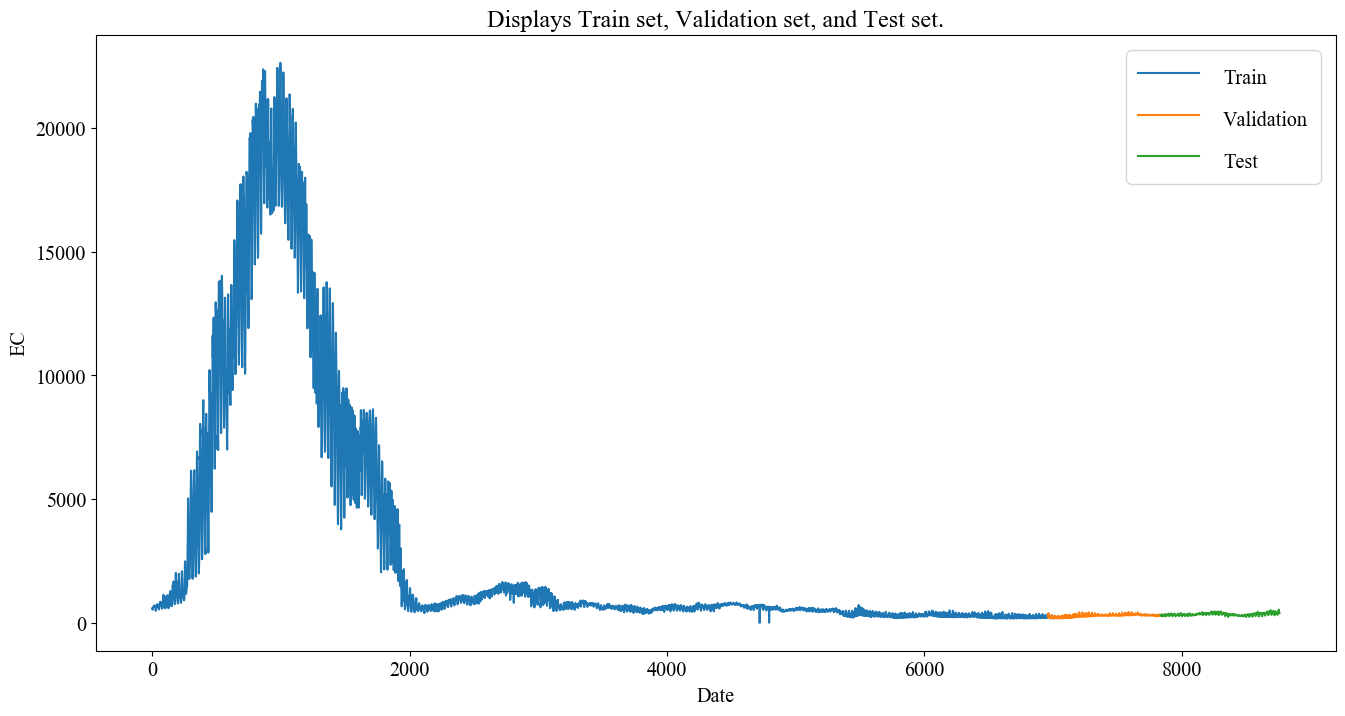

In [18]:
plt.figure(figsize=(16,8))
plt.title('Displays Train set, Validation set, and Test set.')
plt.xlabel('Date')
plt.ylabel('EC')
plt.plot(df[0:train_set_len]["ec"], label='Train')
plt.plot(df[train_set_len - n_past:train_set_len + valid_set_len]["ec"], label='Validation')
plt.plot(df[(train_set_len + valid_set_len) - n_past:]["ec"], label='Test')
plt.legend()
plt.show()

In [19]:
from keras import Model
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import SimpleRNN
from keras.layers import LSTM
# from keras.layers import CuDNNLSTM
from keras.layers import Bidirectional
# from tensorflow.keras.layers import Bidirectional
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [20]:
# =============================================================================
# LSTM
# =============================================================================

model = Sequential()
model.add(LSTM(192, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
# model.add(LSTM(192, return_sequences=True))
model.add(LSTM(192, return_sequences=False))
model.add(Dense(n_future))

# model = Sequential()
# model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
# model.add(LSTM(64, return_sequences=False))
# model.add(Dense(n_future))
# model.add(Dense(16))
# model.add(Dense(1))

In [21]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 48, 192)           148992    
                                                                 
 lstm_1 (LSTM)               (None, 192)               295680    
                                                                 
 dense (Dense)               (None, 24)                4632      
                                                                 
Total params: 449,304
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 48, 192)           148992    
                                                                 
 lstm_1 (LSTM)               (None, 192)               295680    
                                                                 
 dense (Dense)               (None

In [22]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

In [23]:
# checkpoint_filepath = 'checkpoint/lstm-meter-24-3-2-1-gpu-batch-24.h5'
checkpoint_filepath = 'checkpoint/lstm-24-2022-batch-24.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_freq='epoch',
    verbose=1
    )

In [24]:
model_fit = model.fit(
    x_train,
    y_train,
    batch_size=24,
    epochs=128,
    validation_data=(x_valid, y_valid),
    callbacks=[model_checkpoint_callback, early_stopping_callback]
    )

Epoch 1/128
289/290 [============================>.] - ETA: 0s - loss: 0.0032 - mse: 0.0032
Epoch 1: val_loss improved from inf to 0.00001, saving model to checkpoint\lstm-24-2022-batch-24.h5
290/290 [==============================] - 37s 111ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 9.0319e-06 - val_mse: 9.0319e-06
Epoch 2/128
289/290 [============================>.] - ETA: 0s - loss: 9.9563e-04 - mse: 9.9563e-04
Epoch 2: val_loss did not improve from 0.00001
290/290 [==============================] - 31s 108ms/step - loss: 9.9582e-04 - mse: 9.9582e-04 - val_loss: 2.8909e-05 - val_mse: 2.8909e-05
Epoch 3/128
289/290 [============================>.] - ETA: 0s - loss: 9.9142e-04 - mse: 9.9142e-04
Epoch 3: val_loss did not improve from 0.00001
290/290 [==============================] - 33s 113ms/step - loss: 9.9128e-04 - mse: 9.9128e-04 - val_loss: 3.9434e-05 - val_mse: 3.9434e-05
Epoch 4/128
289/290 [============================>.] - ETA: 0s - loss: 8.1819e-04 - mse: 8.1819e-04
Ep

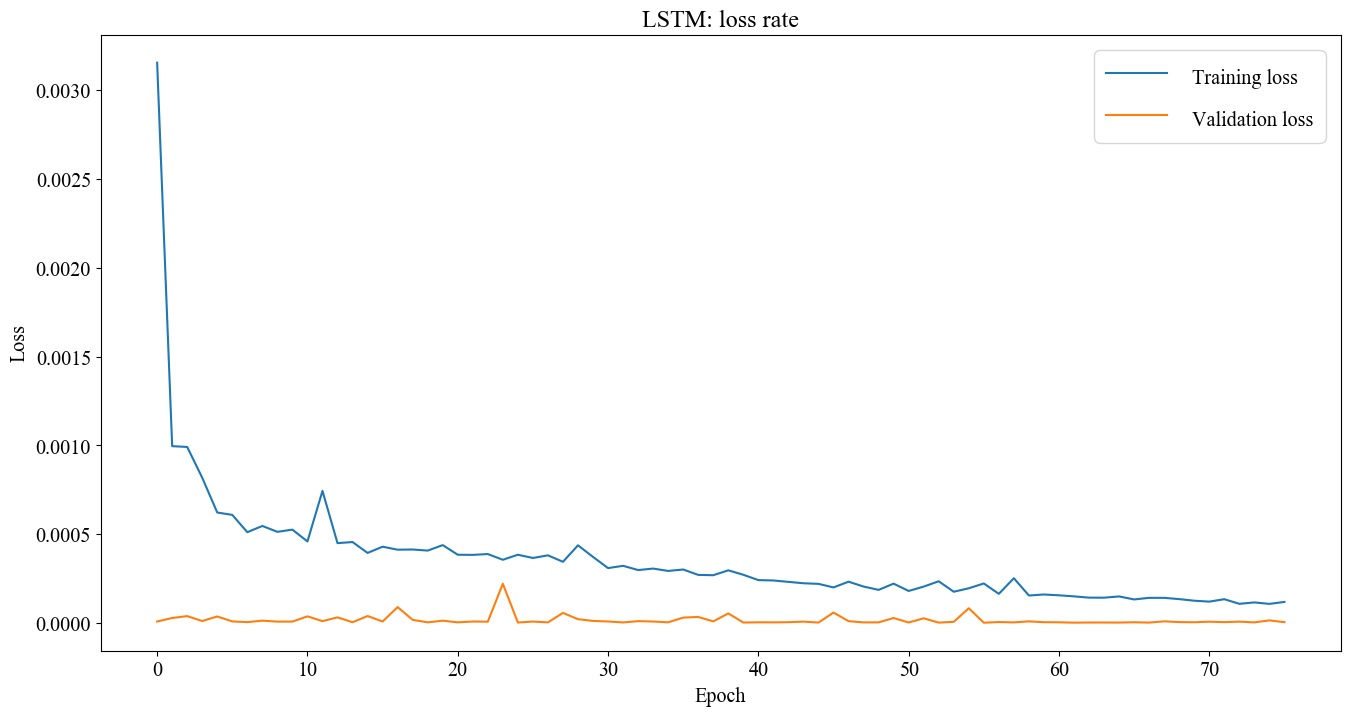

In [25]:
plt.figure(figsize=(16,8))
plt.title('LSTM: loss rate')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(model_fit.history['loss'], label='Training loss')
plt.plot(model_fit.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()


# #%%
# from keras.models import load_model

# model = load_model('checkpoint/01-bilstm-24-3-2-1.h5')

# #%%
# pred = model.predict(x_test)

# #%%
# if dataset.shape[1] > 1:
#     pred = np.repeat(pred, dataset.shape[1], axis=-1)

# #%%
# y_pred = scaler.inverse_transform(pred)[:,0]

# #%%
# y_pred = np.reshape(y_pred, (y_pred.shape[0], 1))

# #%%
# from sklearn.metrics import mean_squared_error

# rmse = mean_squared_error(y_test, y_pred, squared=False)
# print(f'RMSE of Bi-LSTM = {rmse}')            

# #%%
# # rmse = np.sqrt(np.mean(np.square((y_test - y_pred))))
# # print(rmse)

# #%%
# rmspe = (np.sqrt(np.mean(np.square((y_test - y_pred) / y_test)))) * 100
# print(f'RMSPE of Bi-LSTM = {rmspe}')


# #%%
# df_compare = pd.DataFrame({'Actual EC':df['ec_corrected'][train_set_len + valid_set_len:]})
# df_compare['Predicted EC'] = y_pred

# #%%
# plt.figure(figsize=(16,8))
# plt.title('Displays Actual EC vs. Predicted EC.')
# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.plot(df_compare['Actual EC'], label='Actual')
# plt.plot(df_compare['Predicted EC'], label='Predicted')
# plt.legend()
# plt.show()

# #%%
# plt.figure(figsize=(16,8))
# plt.title('Displays All Actual EC vs. Predicted EC.')
# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.plot(df['ec_new_.5'], label='All Actual EC')
# plt.plot(df_compare['Predicted EC'], label='Predicted')
# plt.legend()
# plt.show()

In [26]:
from keras.models import load_model

model = load_model('checkpoint/lstm-24-2022-batch-24.h5')

In [27]:
pred = model.predict(x_test)

27/27 [==============================] - 2s 34ms/step


In [28]:
rpred = None

In [29]:
for i in range(pred.shape[1]):
    tpred = pred[:,i]
    tpred = np.reshape(tpred, (tpred.shape[0], 1))
    tpred = np.repeat(tpred, dataset.shape[1], axis=-1)
    tpred = scaler.inverse_transform(tpred)[:,0]
    tpred = np.reshape(tpred, (tpred.shape[0], 1))
    if rpred is None:
        rpred = tpred
    else:
        rpred = np.append(rpred, tpred, axis=1)

In [30]:
y_pred = rpred[:,0]
y_pred = np.reshape(y_pred, (y_pred.shape[0], 1))

In [31]:
y_test = np.reshape(y_test, (y_test.shape[0], y_test.shape[1]))

In [32]:
y_real = y_test[:,0]
y_real = np.reshape(y_real, (y_real.shape[0], 1))

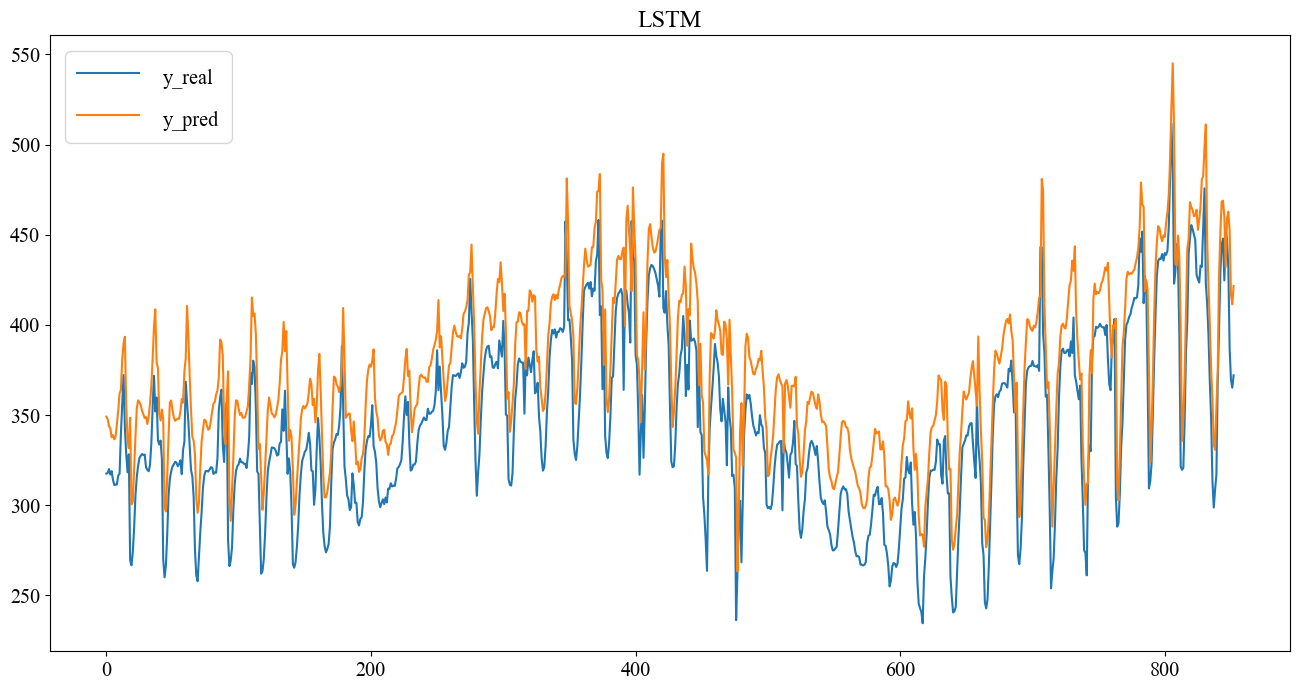

In [33]:
plt.figure(figsize=(16,8))
plt.title('LSTM')
plt.plot(y_real, label='y_real')
plt.plot(y_pred, label='y_pred')
plt.legend()
plt.show()

In [34]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y_test, rpred, squared=False)
print("RMSE of LSTM =",rmse)

RMSE of LSTM = 30.487332435923076


In [35]:
from sklearn.metrics import mean_absolute_percentage_error

# calculate MAPE
mape = mean_absolute_percentage_error(y_test, rpred)
print(f'MAPE of LSTM = {mape}')

MAPE of LSTM = 0.07285345447945384
